## TP3 : Classification avec LDA & QDA

Commençons avec quelques préparatifs :

In [1]:
import csv
from pylab import *
import numpy as np
from numpy import linalg as la

## Charger les données synthétiques
Charger les données d'entraînement et de test à partir des fichiers `synth_train.txt` et
`synth_test.txt`. 
Les targets appartiennent à  $\mathcal{Y} = \left\lbrace 0;1 \right\rbrace$ et les inputs vivent dan $\mathbb{R}^2$.
Il y a 200 données d'apprentissage et 200 de test.

* La première colonne contient les labels, 
* Les colonnes 2 & 3 contiennent les vecteurs d'entrée.

Définissez des numpy arrays 2D `X_train` et `X_test` contenant les inputs de train et de test respectivement. Même chose avec les labels et deux autres numpy arrays 1D `y_train` et `y_test`.

`X_train` possède 200 lignes et 2 colonnes

In [2]:
train = np.loadtxt('synth_train.txt')
test = np.loadtxt('synth_test.txt')

X_train = train[:,1:3]
X_test = test[:,1:3]
y_train = train[:,0]
y_test = test[:,0]

print("X_train.shape : " + str(X_train.shape))
print("y_train.shape : " + str(y_train.shape))
print("X_test.shape : " + str(X_test.shape))
print("y_test.shape : " + str(y_test.shape))

X_train.shape : (100, 2)
y_train.shape : (100,)
X_test.shape : (200, 2)
y_test.shape : (200,)


## Rappel des étapes de LDA :
Pour l'apprentissage :
* estimation de la proba  $\pi$ d'appartenance à la classe $y=1$,
* estimation des vecteurs moyens $\mu_0$ et $\mu_1$ pour chaque classe, 
* estimation matrices de covariances empiriques  $\Sigma_0$ et $\Sigma_1$ pour chaque classe,
* calcul de leur combinaison convexe $\Sigma = (1-\pi) \Sigma_0 + \pi \Sigma_1$,

Pour la prédiction pour une input $\mathbf{x}$ donnée :
* calcul des probabilités d'appartenance aux classe 0 et 1 : $p(Y=0,X=\mathbf{x})$ et $p(Y=1,X=\mathbf{x})$,
* élection de la classe prédite $\hat{y}$ qui maximise ces deux probabilités

On rappelle que dans le modèle de la LDA $p(Y=i,X=\mathbf{x}) = p(Y=i) \times \mathcal{N}(\mu_i, \Sigma)(\mathbf{x}) $.

On rappelle aussi qu'en supposant que $\pi = 1- \pi  = \frac{1}{2}$, alors la frontière de décision passe en le point $\frac{\mu_0 + \mu_1}{2} $ et est orthogonale au vecteur $\mu_1 - \mu_0$.


## Travail : 
1. Créer une classe python correspondant à LDA. Les paramètres à apprendre seront des attributs. Une méthode `fit`  se chargera de l'estimation des paramètres. Une méthode `predict` fournira une prédiction pour une input $\mathbf{x}$ donnée.
2. Entraîner une instance `lda` votre classe LDA sur les données synthétique d'apprentissage.
3. Calculer le taux de bonne classification obtenu sur l'ensemble de test. 
4. Modifier la méthode `predict` pour qu'elle fournisse une seconde sortie : la proba conditionelle $p(Y=1|\mathbf{x})= \frac{p(X=\mathbf{x},Y=1)}{p(X=\mathbf{x},Y=0) + p(X=\mathbf{x},Y=1)}$.
5. On rappelle que QDA est un algorithme cousin de LDA pour lequel les gaussiennes ne partagent plus la même matrice $\Sigma$ mais utilisent respectivement $\Sigma_0$ et $\Sigma_1$. Créer une classe QDA.
6. Entraîner et tester votre classe QDA sur les données synthétiques et comparer les performances vis à vis de LDA.

_Indication 1 : Les matrices "sigma" sont toutes de taille 2x2 dans ce TP._




In [20]:
import math

class LDA:
    mu1, mu2 = -1, -1
    cov = None
    X_train, y_train, X_test, y_test = None, None, None, None
    
    def fit(self, _X_train, _y_train):
        self.X_train = np.array(_X_train, copy=True)
        self.y_train = np.array(_y_train, copy=True)
                
        self.mu1 = self.X_train[self.y_train == 1].mean(axis=0)
        self.mu2 = self.X_train[self.y_train == 2].mean(axis=0)   
                
        self.cov = np.cov(self.X_train.T)
        
    def predict(self, _X_test):
        self.X_test = np.array(_X_test, copy=True)
        
        p = ((2*math.pi)**(-self.X_train.shape[1]/2))*(np.linalg.det(self.cov)**(-.5))
                
        z1 = (self.X_test - self.mu1)
        z2 = (self.X_test - self.mu2)
        prob_1, prob_2, prob_3 = [], [], []
        for i in range(len(z1)):
            prob_1 += [p * np.exp((-1/2)*z1[i].T@np.linalg.inv(self.cov)@z1[i])]
            prob_2 += [p * np.exp((-1/2)*z2[i].T@np.linalg.inv(self.cov)@z2[i])]
            prob_3 += [prob_1[i] / (prob_1[i]+prob_2[i])]
        
        prob1 = []
        for p1, p2 in zip(prob_1, prob_2):
            if p1 > p2:
                prob1 += [1]
            else:
                prob1 += [2]
        
        return np.array(prob1), np.array(prob_3)
    
    def accuracy(self,y_test,y_pred):
        acc = 0
        for k in range(len(y_pred)):
            if y_pred[k] == y_test[k]:
                acc += 1
        acc = acc / len(y_pred)
        return acc
        
lda = LDA()
lda.fit(X_train, y_train)
pred, proba = lda.predict(X_test)
lda.accuracy(y_test, pred)

0.935

Si vous avez correctement programmé votre classe LDA et que `lda` en est une instance alors le code ci-dessous doit afficher la carte de probabilité d'appartenance à la classe n°1. 

Vérifier la cohérence du modèle appris.

(300, 2)


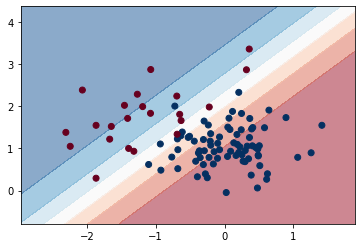

In [21]:
import matplotlib.pyplot as plt

X = np.vstack((X_train,X_test))
print(X.shape)
h = .02
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
_,Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
cm = plt.cm.RdBu
plt.contourf(xx, yy, Z.reshape((xx.shape)), cmap=cm, alpha=.5)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm)

=> On remarque bien que le modèle arrive à séparer la plupart des points.

In [22]:
import math

class QDA:
    mu1, mu2 = -1, -1
    cov1, cov2 = None, None
    X_train, y_train, X_test, y_test = None, None, None, None
    
    def fit(self, _X_train, _y_train):
        self.X_train = np.array(_X_train, copy=True)
        self.y_train = np.array(_y_train, copy=True)
                
        self.mu1 = self.X_train[self.y_train == 1].mean(axis=0)
        self.mu2 = self.X_train[self.y_train == 2].mean(axis=0)   
                
        self.cov1 = np.cov(self.X_train[self.y_train == 1].T)
        self.cov2 = np.cov(self.X_train[self.y_train == 2].T)
        
        
    def predict(self, _X_test):
        self.X_test = np.array(_X_test, copy=True)
        
        p = ((2*math.pi)**(-self.X_train.shape[1]/2))
                
        z1 = (self.X_test - self.mu1)
        z2 = (self.X_test - self.mu2)
        prob_1, prob_2, prob_3 = [], [], []
        for i in range(len(z1)):
            prob_1 += [p * np.exp((-1/2)*z1[i].T@np.linalg.inv(self.cov1)@z1[i]) *(np.linalg.det(self.cov1)**(-.5))]
            prob_2 += [p * np.exp((-1/2)*z2[i].T@np.linalg.inv(self.cov2)@z2[i]) *(np.linalg.det(self.cov2)**(-.5))]
            prob_3 += [prob_1[i] / (prob_1[i]+prob_2[i])]
        
        prob1 = []
        for p1, p2 in zip(prob_1, prob_2):
            if p1 > p2:
                prob1 += [1]
            else:
                prob1 += [2]
        
        return np.array(prob1), np.array(prob_3)
    
    def accuracy(self,y_test,y_pred):
        acc = 0
        for k in range(len(y_pred)):
            if y_pred[k] == y_test[k]:
                acc += 1
        acc = acc / len(y_pred)
        return acc
        
qda = QDA()
qda.fit(X_train, y_train)
pred, proba = qda.predict(X_test)
qda.accuracy(y_test, pred)

0.955

(300, 2)


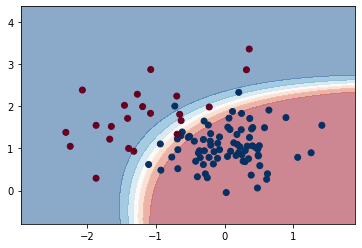

In [24]:
import matplotlib.pyplot as plt

X = np.vstack((X_train,X_test))
print(X.shape)
h = .02
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
_,Z = qda.predict(np.c_[xx.ravel(), yy.ravel()])
cm = plt.cm.RdBu
plt.contourf(xx, yy, Z.reshape((xx.shape)), cmap=cm, alpha=.5)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm)

## Remarque : LDA & QDA dans le module scikit-learn 

Le module `scikit-learn` propose de nombreux algorithmes de machine learning assez facile d'emploi. Pour LDA et QDA, vous pouvez jeter un oeil au tutoriel suivant : http://scikit-learn.org/stable/modules/lda_qda.html 

Ces implémentations peuvent vous servir à valider votre code. Il n'est pas obligatoire de mener la comparaison.




In [29]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [30]:
clf = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
pred = clf.fit(X_train, y_train).predict(X_test)
print('lda : ' + str(clf.score(X_test, y_test)))

clf = QuadraticDiscriminantAnalysis(store_covariance=True)
pred = clf.fit(X_train, y_train).predict(X_test)
print('qda : ' + str(clf.score(X_test, y_test)))

lda : 0.945
qda : 0.95
